# Time Spent in the Bonus

In [299]:
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [523]:
west = ['GSW','LAC','SAS','HOU','POR','DAL','OKC','PHX','MEM','UTA','SAC','DEN','NOP','LAL','MIN']

def addToDict(team, win, a, b, periods):
    '''
    turns our game information into dictionaries. The numbered positive entries are the time
    a team spent in the bonus, and the negative are their opponent.
    '''
    a = dict(a)
    b = dict(b)
    a['team'] = team
    a['win'] = win
    a['west'] = 1 if team in west else 0
    for i in range(1, max(periods + 1)):
        if i in a.keys():
            a[i] = 60*int(a[i][3:5]) + int(a[i][6:])
        if i in b.keys():
            a[-i] = 60*int(b[i][3:5]) + int(b[i][6:])
    return a
        
def bonusTime(dfIn, year):
    '''
    Given a DataFrame for a game and the year, returns dictionaries of the time the teams spent in the bonus.
    The year corrects for the 2016 data including the referee who called the foul.
    '''
    teams = dfIn['team'].dropna().unique()
    periods =  dfIn['period'].dropna().unique()
    final = dict(dfIn.groupby('team').sum()['points'].iteritems())
    
    df = dfIn#[dfIn['period']<=4]
    if year != 2015:
        df['Total Fouls'] = df[df['event_type']=='foul']['description'].fillna('123').apply(lambda x: x[-3:-1])
    else:
        df['Total Fouls'] = df[df['event_type']=='foul']['description'].fillna('a a a a').apply(lambda x: x.split()[-2][-3:-1])
    bTimes = df[(df['event_type'] == 'foul') & (df['Total Fouls'] == 'PN')][['period','remaining_time','team']].groupby('team')
    
    
    bonuses= []
    for team in teams:
        opp = list(set(teams) - set([team]))[0]
        try:
            a = bTimes.get_group(opp).groupby('period')['remaining_time'].max().iteritems()
        except:
            a = []
        try:
            b = bTimes.get_group(team).groupby('period')['remaining_time'].max().iteritems()
        except:
            b = []

        bonuses.append( addToDict(team, 1 if final[team] == max(final.values()) else 0,\
                         a, b, periods))
    return bonuses

In [524]:
# read in all the data for a given year
scores = []

for csv in glob.glob('2015-16/*.csv'):
    g1 = pd.read_csv('{}'.format(csv))
    #The check here is so we only include regualr season games
    if g1['data_set'].unique()[0] != '2015-2016 Regular Season':
        continue
    else:
        try:
            scores.extend(bonusTime(g1,2015))
        except:
            print csv
            
scores = pd.DataFrame.from_dict(scores)

In [527]:
#merge, sort, and make a nice reddit formatted table

l = list(scores.fillna(0).groupby('team').mean().sort_values(by=['west','win'], ascending=(True,False))\
         [[1,-1,2,-2,3,-3,4,-4,'win']].iterrows())

for i in l:
    a = sum([round(j[1], 2) for j in i[1].iteritems()][:-1:2])
    b = sum([round(j[1], 2) for j in i[1].iteritems()][1:-1:2])
    print '{}|{} ({})|{} ({})|{} ({})|{} ({})|{} ({})'.format(i[0],a,b,*[round(j[1], 2) for j in i[1].iteritems()])
print 'League|{}|{}|{}|{}|{}'.format(round(sum(scores.fillna(0)[[1,2,3,4]].mean()), 2),\
                                     *map(lambda x: round(x ,2), scores.fillna(0)[[1,2,3,4]].mean()))

CLE|426.11 (378.26)|55.98 (34.73)|115.52 (102.27)|113.62 (104.46)|140.99 (136.8)
TOR|446.7 (356.85)|69.83 (46.0)|125.26 (80.27)|109.71 (139.07)|141.9 (91.51)
ATL|305.26 (346.19)|28.04 (22.5)|60.43 (81.32)|94.57 (118.74)|122.22 (123.63)
BOS|403.87 (490.83)|43.88 (61.99)|94.44 (127.61)|139.05 (148.72)|126.5 (152.51)
CHA|402.16 (270.5)|40.71 (28.6)|110.99 (94.85)|103.45 (71.48)|147.01 (75.57)
MIA|392.09 (295.76)|45.24 (32.37)|96.78 (64.59)|105.11 (89.17)|144.96 (109.63)
IND|425.67 (377.5)|51.13 (43.18)|79.39 (71.51)|139.59 (123.61)|155.56 (139.2)
DET|406.46 (302.13)|32.4 (27.17)|125.38 (76.07)|118.59 (90.21)|130.09 (108.68)
CHI|348.09 (329.62)|43.22 (25.26)|85.88 (79.22)|119.66 (87.49)|99.33 (137.65)
WAS|399.52 (434.75)|31.35 (41.0)|137.79 (134.49)|97.62 (90.93)|132.76 (168.33)
ORL|301.31 (424.4)|21.9 (58.98)|83.02 (114.02)|84.98 (113.0)|111.41 (138.4)
MIL|364.95 (422.02)|55.1 (53.54)|81.84 (118.2)|91.71 (130.48)|136.3 (119.8)
NYK|340.16 (360.46)|32.83 (47.37)|104.3 (88.38)|88.6 (99.33)|1

## Plotting

In [475]:
v2014 = scores.fillna(0).groupby('team').mean()

In [479]:
v2015 = scores.fillna(0).groupby('team').mean()

In [528]:
v2016 = scores.fillna(0).groupby('team').mean()

In [544]:
# Lightning is a nice interactive plotting library
from lightning import Lightning
import random
#lgn = Lightning(local=True)
lgn = Lightning(host='http://public.lightning-viz.org')

Lightning initialized
Connected to server at http://public.lightning-viz.org


In [583]:
x=[]
y=[]
g=['2014']*30+['2015']*30+['2016']*30
l=[]
for i in [v2014, v2015, v2016]:
    x.extend(list(0.25*(i[1]-i[-1] + i[2]-i[-2]+ i[3]-i[-3]+ i[4]-i[-4])))
    y.extend(map(lambda x: 100*x , list(i['win'])))
    l.extend(list(i.index))

In [576]:
v=lgn.scatter(x=x, y=y, group=g, labels=map(lambda (i,j): i + ' ' + j, zip(l,g)),\
             alpha = 0.8, xaxis='Extra Time Spent in Bonus [s]', yaxis='Winning Percentage')
v.open()

In [579]:
from scipy.stats import pearsonr,linregress

In [600]:
x2=[]
y=[]
for i in [v2014, v2015, v2016]:
    x2.extend(list((i[1]-i[-1])))
    y.extend(map(lambda x: 100*x , list(i['win'])))

In [612]:
print pearsonr(x2,y)
print pearsonr(x,y)

(0.47243093636507211, 2.5852902382360367e-06)
(0.22889984608553143, 0.030000836339967769)


In [608]:
v=lgn.scatter(x=x2, y=y, group=g, labels=map(lambda (i,j): i + ' ' + j, zip(l,g)),\
             alpha = 0.8, xaxis='Extra Time Spent in Bonus 1Q [s]', yaxis='Winning Percentage')
v.open()

In [609]:
# Moving average of time spent in bonus for 2016 season
b = sum([scores.fillna(0).groupby('team').get_group(team)[[1,2,3,4]].as_matrix() for team in scores['team'].unique()])/30.

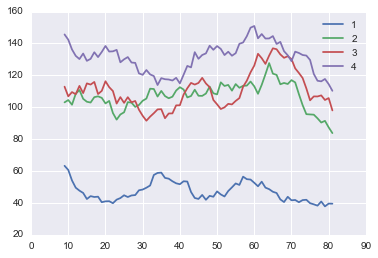

In [611]:
lineObjects = plt.plot(pd.rolling_mean(b,10))
plt.legend(lineObjects, ('1Q','2Q','3Q','4Q'))